<a href="https://cognitiveclass.ai"><img src = "https://ibm.box.com/shared/static/9gegpsmnsoo25ikkbl4qzlvlyjbgxs5x.png" width = 400> </a>

<h1 align=center><font size = 5>IBM Capstone Project: The Battle of the Neighborhoods</font></h1>
<h3 align=center>Open new Turkish Restaurant in Bucharest, Romania</h3>

## Introduction

In this project, I will try to determine which place is good for opening Turkish Restaurant in Bucharest, Romania 

* I will convert addresses into their equivalent latitude and longitude values. 
* I will use the Foursquare API to explore neighborhoods in Bucharest. I will use the **explore** function to get the most common venue categories in each neighborhood, and then use this feature to group the neighborhoods into clusters. 
* I will use the *k*-means clustering algorithm to complete clustering task
* I will use the Folium library to visualize the neighborhoods, venues , clusters in Bucharest
* For Bucharest neighborhood data, I will use wikipedia , https://en.wikipedia.org/wiki/Category:Districts of Bucharest


## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>
1. <a href="#item1">Download and Explore Neigborhood Dataset</a><br>
2. <a href="#item2">Load and Analyze Venues of Neighborhoods in Bucharest</a><br>
3. <a href="#item3">Cluster Neighborhoods</a><br>
&emsp;<a href="#item3.1">3.1. Cluster using K - mean algorithm</a><br>
&emsp;<a href="#item3.2">3.2. Cluster using Agglomerative Clustering</a><br>
4. <a href="#item4">Examine Results</a><br>    
</font>
</div>

<a id='item1'></a>
## 1. Download and Explore Neigborhood Dataset

#### Import Libraries

In [8]:
#install libraries 
#!pip install geopy    
#!pip install folium   
#!pip install geocoder

In [454]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt # for graphical usage 

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # to get coordinates

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
from folium import plugins
from folium.plugins import HeatMap

# main documentation page: http://beautiful-soup-4.readthedocs.io/en/latest/
# how to use the BeautifulSoup package: https://www.youtube.com/watch?v=ng2o98k983k video
from bs4 import BeautifulSoup 
import pandas as pd
import requests

print('Libraries imported.')

Libraries imported.


#### Get geocoordinates of Bucharest, Romania

In [455]:
# get coordinates of Bucharest
bucharest_address = 'Bucharest, Romania'

geolocator = Nominatim(user_agent="bucharest_explorer")
location = geolocator.geocode(bucharest_address)
latitude = location.latitude
longitude = location.longitude
bucharest_center = [latitude, longitude ]
print('The geograpical coordinate of {} are {}, {}.'.format(bucharest_address, latitude, longitude))

The geograpical coordinate of Bucharest, Romania are 44.4361414, 26.1027202.


#### Scraping web for neighborhood data of Bucharest

I used wikiPedia, "Category:Districts of Bucharest" for getting neighborhoods of Bucharest . 

In [456]:
# Read Bucharest neighborhood data 
url = "https://en.wikipedia.org/wiki/Category:Districts of Bucharest"
source = requests.get(url).text
soup = BeautifulSoup(source,'lxml')

neighborhoodList = []

# append the data into the list
for row in soup.find_all("div", class_="mw-category")[0].findAll("li"):
    neighborhoodList.append(row.text)
    
df_neighborhood = pd.DataFrame({"Neighborhood": neighborhoodList})
print("There are {} neighborhoods in {}".format(df_neighborhood.shape[0], bucharest_address))


There are 40 neighborhoods in Bucharest, Romania


#### Get geographical coordinates of neighborhoods
I use python geocoder library to get geograpical coordinates of neighborhoods

In [457]:
# define a function to get coordinates
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, {}'.format(neighborhood,bucharest_address))
        lat_lng_coords = g.latlng
    return lat_lng_coords

coords = [ get_latlng(neighborhood) for neighborhood in df_neighborhood["Neighborhood"].tolist() ]

df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

# merge the coordinates into the original dataframe
df_neighborhood['Latitude'] = df_coords['Latitude']
df_neighborhood['Longitude'] = df_coords['Longitude']
print("Five of neighborhoods are as below")
df_neighborhood.head()

Five of neighborhoods are as below


,Neighborhood,Latitude,Longitude
0,Aviației,44.485790,26.101219
1,"Băneasa, Bucharest",44.493952,26.080518
2,"Berceni, Bucharest",44.386430,26.128490
3,Bucureștii Noi,44.480413,26.042807
4,Centrul Civic,44.434300,26.094670


#### Create Bucharest map with neighborhoods superimposed
Let's see locations of neighborhoods on map. In here, I use folium library to draw map

In [458]:
#create map of Bucharest neighborhoods using latitude and longitude values
map_bucharest= folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng,  neighborhood in zip(df_neighborhood['Latitude'], df_neighborhood['Longitude'], df_neighborhood['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bucharest)  
    
map_bucharest

<a id='item2'></a>
# 2. Load Venues and Analyze Neighborhoods in Bucharest

We will use Foursquare API for getting venues of neighborhoods

#### Explore Venues of Bucharest neighborhoods
I get venue list with 1 km distance to neighborhood's center

In [459]:
# The code was removed by Watson Studio for sharing.

In [465]:
LIMIT = 100

def getNeighborhoodVenues( latitude, longitude,neighborhood, radius=1000 ):
    venues = []
    for lat, long, neighborhood in zip(latitude, longitude ,neighborhood):

        # create the API request URL
        url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            long,
            radius, 
            LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        for venue in results:
            venues.append((
                neighborhood,
                lat, 
                long, 
                venue['venue']['name'], 
                venue['venue']['id'], 
                venue['venue']['location']['lat'], 
                venue['venue']['location']['lng'],  
                venue['venue']['location']['distance'],  
                venue['venue']['categories'][0]['name']))
    
    # convert the venues list into a DataFrame
    venues = pd.DataFrame(venues)
    # define the column names
    venues.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueId', 'VenueLatitude', 'VenueLongitude','VenueDistance','VenueCategory']
            
    return venues 

neighborhood_venues = getNeighborhoodVenues (df_neighborhood['Latitude'], df_neighborhood['Longitude'], df_neighborhood['Neighborhood'] )

print('There are {} unique categories. Some of them are as below:'.format(len(neighborhood_venues['VenueCategory'].unique())))
neighborhood_venues.head()

There are 223 unique categories. Some of them are as below:


,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory
0,Aviației,44.48579,26.101219,LIDL,583956246d349d0574eb02ac,44.488396,26.094375,616,Supermarket
1,Aviației,44.48579,26.101219,Mega Image Concept Store,56348b62498e53f51a0a4e0e,44.479783,26.102568,677,Supermarket
2,Aviației,44.48579,26.101219,Flying Pig,58a2fc95d0bb3e516a2363b7,44.479454,26.102837,716,Burger Joint
3,Aviației,44.48579,26.101219,Starbucks,525fd077498eed1c5a52c1d6,44.478522,26.102503,815,Coffee Shop
4,Aviației,44.48579,26.101219,Mega Image,4eb5452b30f8d0f18c41dfec,44.487255,26.092758,691,Supermarket


In [466]:
print('Top 10 distinct venue counts are as below')
neighborhood_venues[['VenueId','VenueCategory']].drop_duplicates().groupby('VenueCategory').count()[['VenueId']].sort_values(by=['VenueId'], ascending=False)[:10]

Top 10 distinct venue counts are as below


,VenueId
VenueCategory,
Café,72
Restaurant,67
Italian Restaurant,58
Coffee Shop,55
Supermarket,52
Pizza Place,47
Gym,40
Hotel,39
Romanian Restaurant,35


#### Filter restaurants out of all venues
Let's filter venues and get only restaurants 

In [467]:
restaurant_list =['Restaurant', 'Burger Joint','Café','Fried Chicken Joint','Pizza Place']
turkish_restaurant_list = ['Turkish Restaurant', 'Doner Restaurant']

# Filter restaurants 
    
neighborhood_venues['RestFlag']=False
for restCat in restaurant_list:
    neighborhood_venues['RestFlag'] = neighborhood_venues['RestFlag'] | neighborhood_venues['VenueCategory'].str.contains(restCat)
    
neighborhood_restaurants = neighborhood_venues[neighborhood_venues['RestFlag'] == True].iloc[:,:-1]
turkish_restaurants = neighborhood_restaurants[ neighborhood_restaurants['VenueCategory'].isin(turkish_restaurant_list) ]
other_restaurants = neighborhood_restaurants[ ~neighborhood_restaurants['VenueCategory'].isin(turkish_restaurant_list) ]

print('Total number of restaurants:', len(neighborhood_restaurants['VenueId'].unique()))
print('Total number of Turkish restaurants:', len(turkish_restaurants['VenueId'].unique()))
print('Percentage of Turkish restaurants: {:.2f}%'.format(len(turkish_restaurants['VenueId'].unique()) / len(neighborhood_restaurants['VenueId'].unique()) * 100))


Total number of restaurants: 499
Total number of Turkish restaurants: 20
Percentage of Turkish restaurants: 4.01%


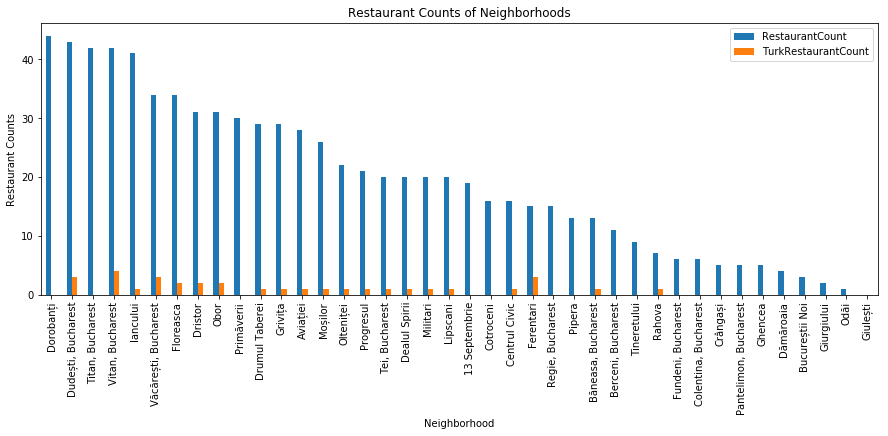

In [468]:
# get counts of restaurants in each Neighborhood
df_rest_counts =  neighborhood_restaurants.groupby(['Neighborhood']).count().rename(columns={"VenueCategory": "RestaurantCount"})[['RestaurantCount']]

#find neighborhoods that does not have any restaurant 
noRestList = list(set(neighborhood_venues['Neighborhood']) - set(neighborhood_restaurants['Neighborhood']))

#if exists , append neighborhoods without any restaurant to df_rest_counts
if noRestList != []:
    df_rest_counts = df_rest_counts.append (pd.DataFrame( {'Neighborhood' : noRestList  , 'RestaurantCount': [0] * len(noRestList) } ).set_index('Neighborhood'))

df_rest_counts.reset_index(inplace=True)

#####
# get counts of Turkish restaurants in each Neighborhood
df_turk_rest_counts =  turkish_restaurants.groupby(['Neighborhood']).count().rename(columns={"VenueCategory": "TurkRestaurantCount"})[['TurkRestaurantCount']]

#find neighborhoods that does not have any restaurant 
noRestList = list(set(neighborhood_venues['Neighborhood']) - set(turkish_restaurants['Neighborhood']))

#if exists , append neighborhoods without any restaurant to df_rest_counts
if noRestList != []:
    df_turk_rest_counts = df_turk_rest_counts.append (pd.DataFrame( {'Neighborhood' : noRestList  , 'TurkRestaurantCount': [0] * len(noRestList) } ).set_index('Neighborhood'))

df_turk_rest_counts.reset_index(inplace=True)
df_rest_counts= df_rest_counts.merge(df_turk_rest_counts).set_index('Neighborhood')
df_rest_counts= df_rest_counts.sort_values(by=['RestaurantCount'],ascending =False)

#######
#Draw graph
df_rest_counts[['RestaurantCount','TurkRestaurantCount']].plot(kind='bar',figsize=(15,5))
plt.title('Restaurant Counts of Neighborhoods')
plt.xlabel('Neighborhood')
plt.ylabel('Restaurant Counts')
plt.show()



We can see from the Graph :
* Dorobanti is the neihgborhood having most restaurants , but no Tukish restaurant
* Odai and Gluesti are neihgborhoods having least number of restaurants
* 19 neihgborhoods does not have any Turkish restaurant

#### Get the restaurant's overall rating

I used Foursquare for getting likes and rates of restaurants 

In [469]:
def getVenueRaitings(venues):
    
    raitings = []
    likes =[]
    for venueId in venues:

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venueId, CLIENT_ID, CLIENT_SECRET, VERSION)
        result = requests.get(url).json()
        try:
            rating = result['response']['venue']['rating']
            likes = result['response']['venue']['likes']['count']
        except:
            rating = None
            likes = None
        
        raitings.append((venueId, rating,likes))
 
    # convert the venues list into a DataFrame
    rating = pd.DataFrame(raitings)
    # define the column names
    rating.columns = ['VenueId', 'VenueRating','VenueLikes']

    return rating    

restaurants_raitings = getVenueRaitings(neighborhood_restaurants['VenueId'].drop_duplicates())

In [470]:
#merge raitings to restaurants 
neighborhood_restaurants = neighborhood_restaurants.merge(restaurants_raitings)
neighborhood_restaurants.head()

,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory,VenueRating,VenueLikes
0,Aviației,44.485790,26.101219,Flying Pig,58a2fc95d0bb3e516a2363b7,44.479454,26.102837,716,Burger Joint,None,None
1,Floreasca,44.476308,26.103289,Flying Pig,58a2fc95d0bb3e516a2363b7,44.479454,26.102837,351,Burger Joint,None,None
2,Aviației,44.485790,26.101219,trickSHOT,53623e44498ed583ede334f5,44.478378,26.103135,838,Restaurant,None,None
3,Floreasca,44.476308,26.103289,trickSHOT,53623e44498ed583ede334f5,44.478378,26.103135,230,Restaurant,None,None
4,Aviației,44.485790,26.101219,Manufaktura by Doncafé,58bbf8764f1069627380fed5,44.478429,26.104004,848,Café,None,None


In [471]:
#merge raitings to turkish restaurants 
turkish_restaurants = turkish_restaurants.merge(restaurants_raitings)
turkish_restaurants.head()

,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory,VenueRating,VenueLikes
0,Aviației,44.485790,26.101219,Istanbul Taksim,55acc94f498e0a64af6b19af,44.478560,26.103505,825,Turkish Restaurant,None,None
1,Floreasca,44.476308,26.103289,Istanbul Taksim,55acc94f498e0a64af6b19af,44.478560,26.103505,251,Turkish Restaurant,None,None
2,"Băneasa, Bucharest",44.493952,26.080518,Shaormeria Băneasa,5137a298e4b0523475c45b54,44.494460,26.080462,56,Doner Restaurant,None,None
3,Centrul Civic,44.434300,26.094670,Dristor Kebap,4dc58dd7887717c8802694a1,44.429973,26.100381,661,Doner Restaurant,None,None
4,Lipscani,44.432155,26.104057,Dristor Kebap,4dc58dd7887717c8802694a1,44.429973,26.100381,379,Doner Restaurant,None,None


#### Show restaurants on head map 

Let's crete a map showing heatmap / density of restaurants and try to extract some meaningfull info from that. Also, let's show borders of Bucharest on our map and a few circles indicating distance of 2km, 4km, 6km and 10km from Bucharest center

<font color='red'>Red</font> markers are <font color='red'> Turkish </font> restaurants

<font color='Blue'>Blue</font> markers are Turkish restaurants with <font color='blue'> rating less than 7  </font> restaurants

In [472]:
bucharest_center = [latitude, longitude]
map_restaurant= folium.Map(location=bucharest_center, zoom_start=12)

folium.TileLayer('cartodbpositron').add_to(map_bucharest) 
HeatMap(neighborhood_restaurants[['VenueLatitude','VenueLongitude']]).add_to(map_restaurant)
folium.Marker(bucharest_center).add_to(map_bucharest)
folium.Circle(bucharest_center, radius=2000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=4000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=6000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=10000, fill=False, color='black').add_to(map_restaurant)
for lat, lon, neig, name in zip(turkish_restaurants['VenueLatitude'], turkish_restaurants['VenueLongitude'], turkish_restaurants['Neighborhood'], turkish_restaurants['VenueName']):
    label = folium.Popup(str(name) + ' - ' + str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_restaurant)
       
raiting_lt_7 = turkish_restaurants[turkish_restaurants['VenueRating'] <7]
for lat, lon, neig, name in zip(raiting_lt_7['VenueLatitude'], raiting_lt_7['VenueLongitude'], raiting_lt_7['Neighborhood'], raiting_lt_7['VenueName']):
    label = folium.Popup(str(name) + ' - ' + str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_restaurant)        
        
map_restaurant

From heat map , we can see that there are 
* Too many restaurants in 4 km to the center 
* Enough restaurants between 4-6 km to the center 
* There are <b> not many </b> restaurants after <b> 6 km </b>  
* <b> Turkish restaurants are located in South, North , East, between 2-4 Km distance around center </b>
* There are <b> not Turkish Restaurants in West Part.</b>
* Some Turkish restaurants gets bad points. That means people does not prefer these restaurant too much and any turkish restaurant may be opened around

<a id='item3'></a>
# 3. Cluster Neigborhoods

<a id='item3.1'></a>
### 3.1. Cluster using K - mean algorithm

Let's first transpose neighborhoods vs restaurant counts data and normalize data.
Then we will use this data for clustering  

In [473]:
#### Analyse each neighborhood
# one hot encoding
onehot = pd.get_dummies(neighborhood_venues[['VenueCategory']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
onehot['Neighborhood'] = neighborhood_venues['Neighborhood']

venues_grouped = onehot.groupby(["Neighborhood"]).sum().reset_index()

# move neighborhood column to the first column and filter only restaurant columns 
fixed_columns =['Neighborhood'] + list(neighborhood_restaurants['VenueCategory'].unique())
venues_grouped = venues_grouped[fixed_columns]

print("{}  neighborhoods' restaurant category are shown in {} columns as below".format(venues_grouped.shape[0],venues_grouped.shape[1]-1))
venues_grouped.head()

40  neighborhoods' restaurant category are shown in 42 columns as below


,Neighborhood,Burger Joint,Restaurant,Café,Vietnamese Restaurant,Italian Restaurant,Turkish Restaurant,Sushi Restaurant,Pizza Place,Lebanese Restaurant,Middle Eastern Restaurant,Spanish Restaurant,Chinese Restaurant,Mongolian Restaurant,Eastern European Restaurant,Romanian Restaurant,Doner Restaurant,Vegetarian / Vegan Restaurant,Theme Restaurant,Fast Food Restaurant,Korean Restaurant,Swiss Restaurant,Fried Chicken Joint,Indian Restaurant,Australian Restaurant,French Restaurant,Mexican Restaurant,Japanese Restaurant,Scandinavian Restaurant,Asian Restaurant,Mediterranean Restaurant,Modern European Restaurant,Seafood Restaurant,German Restaurant,Molecular Gastronomy Restaurant,Greek Restaurant,American Restaurant,Ramen Restaurant,Kebab Restaurant,Hungarian Restaurant,Comfort Food Restaurant,Falafel Restaurant,Pet Café
0,13 Septembrie,0,5,3,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,2,0,0
1,Aviației,3,4,5,1,1,1,2,4,2,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Berceni, Bucharest",0,0,0,0,1,0,0,3,1,0,0,0,0,4,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Bucureștii Noi,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Băneasa, Bucharest",0,3,1,0,2,0,0,1,0,1,0,0,0,0,2,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Find k for k-means algorithm

We will use unsupervised k-means cluster machine leraning algorithm to find neighborhood clusters. First we should find which k value we should use.<br>
In order to find k value, we will use <b> elbow method<b>

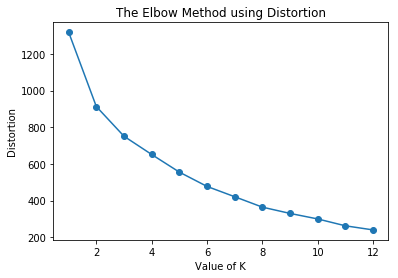

In [474]:
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt  

# calculate distortion for a range of number of cluster
distortions = []
K = 13
neighborhood_clustering = venues_grouped.drop(["Neighborhood"], axis=1)

for k in range(1, K):
    km = KMeans(n_clusters=k)
    km.fit(neighborhood_clustering)
    distortions.append(km.inertia_)
    
# plot
plt.plot(range(1, K), distortions, marker='o')
plt.xlabel('Value of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion') 
plt.show()    

#### Cluster and find similarities between neighborhoods

Accoring to above elbow graph , I get k =5

In [475]:
# fit our data to k-means and find clusters 
kclusters = 5

# run k-means clustering
kmeans = KMeans(init="k-means++", n_clusters=kclusters, n_init=12).fit(neighborhood_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([3, 1, 0, 0, 0, 3, 0, 3, 0, 3, 4, 1, 1, 2, 0, 0, 1, 0, 0, 0, 0, 3,
       1, 3, 3, 3, 1, 0, 1, 0, 0, 3, 3, 0, 0, 3, 0, 4, 2, 3], dtype=int32)

In [476]:
# assign labels to our neighborhood dataframe
merged = venues_grouped.copy()

# add clustering labels
merged["NeighborhoodCluster"] = kmeans.labels_

df_merged = merged[['Neighborhood','NeighborhoodCluster']].merge(df_neighborhood)
df_merged.head()


,Neighborhood,NeighborhoodCluster,Latitude,Longitude
0,13 Septembrie,3,44.424978,26.083313
1,Aviației,1,44.485790,26.101219
2,"Berceni, Bucharest",0,44.386430,26.128490
3,Bucureștii Noi,0,44.480413,26.042807
4,"Băneasa, Bucharest",0,44.493952,26.080518


#### Visualize Clusters

In [477]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for lat, lon, poi, cluster in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Neighborhood'], df_merged['NeighborhoodCluster']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item3.2'></a>
### 3.2. Cluster using Agglomerative Clustering

In [478]:
# one hot encoding
onehot = pd.get_dummies(neighborhood_venues[['VenueCategory']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
onehot['Neighborhood'] = neighborhood_venues['Neighborhood']

venues_grouped = onehot.groupby(["Neighborhood"]).sum().reset_index()

# move neighborhood column to the first column and filter only restaurant columns 
fixed_columns =['Neighborhood'] + list(neighborhood_restaurants['VenueCategory'].unique())
venues_grouped = venues_grouped[fixed_columns]

print("{}  neighborhoods' restaurant category are shown in {} columns as below".format(venues_grouped.shape[0],venues_grouped.shape[1]-1))
venues_grouped.head()

40  neighborhoods' restaurant category are shown in 42 columns as below


,Neighborhood,Burger Joint,Restaurant,Café,Vietnamese Restaurant,Italian Restaurant,Turkish Restaurant,Sushi Restaurant,Pizza Place,Lebanese Restaurant,Middle Eastern Restaurant,Spanish Restaurant,Chinese Restaurant,Mongolian Restaurant,Eastern European Restaurant,Romanian Restaurant,Doner Restaurant,Vegetarian / Vegan Restaurant,Theme Restaurant,Fast Food Restaurant,Korean Restaurant,Swiss Restaurant,Fried Chicken Joint,Indian Restaurant,Australian Restaurant,French Restaurant,Mexican Restaurant,Japanese Restaurant,Scandinavian Restaurant,Asian Restaurant,Mediterranean Restaurant,Modern European Restaurant,Seafood Restaurant,German Restaurant,Molecular Gastronomy Restaurant,Greek Restaurant,American Restaurant,Ramen Restaurant,Kebab Restaurant,Hungarian Restaurant,Comfort Food Restaurant,Falafel Restaurant,Pet Café
0,13 Septembrie,0,5,3,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,2,0,0
1,Aviației,3,4,5,1,1,1,2,4,2,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Berceni, Bucharest",0,0,0,0,1,0,0,3,1,0,0,0,0,4,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Bucureștii Noi,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Băneasa, Bucharest",0,3,1,0,2,0,0,1,0,1,0,0,0,0,2,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [479]:
# create a new dataframe with most common venue catrgories
def return_most_common_venues(row, num_top_venues):
    row_categories = row
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

columns = ['Neighborhood','Total Number of Restaurants']
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Restaurant'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Restaurant'.format(ind+1))

# create a new dataframe
venues_most = pd.DataFrame(columns = columns)

for ind in range(venues_grouped.shape[0]):
    venues_most.loc[ind, 'Neighborhood'] = venues_grouped.iloc[ind].Neighborhood
    venues_most.loc[ind, 'Total Number of Restaurants'] = venues_grouped.iloc[ind,1:].sum()
    venues_most.iloc[ind, 2:] = return_most_common_venues(venues_grouped.iloc[ind, 1:], num_top_venues)

venues_most.head()

,Neighborhood,Total Number of Restaurants,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,13 Septembrie,19,Restaurant,Café,Comfort Food Restaurant,Seafood Restaurant,Romanian Restaurant,Fast Food Restaurant,American Restaurant,Italian Restaurant,Fried Chicken Joint,Indian Restaurant
1,Aviației,28,Café,Restaurant,Pizza Place,Burger Joint,Sushi Restaurant,Lebanese Restaurant,Spanish Restaurant,Eastern European Restaurant,Mongolian Restaurant,Chinese Restaurant
2,"Berceni, Bucharest",11,Eastern European Restaurant,Pizza Place,Fast Food Restaurant,Italian Restaurant,Romanian Restaurant,Lebanese Restaurant,Pet Café,Chinese Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant
3,Bucureștii Noi,3,Korean Restaurant,Restaurant,Café,Chinese Restaurant,Fast Food Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Doner Restaurant,Romanian Restaurant,Eastern European Restaurant
4,"Băneasa, Bucharest",13,Restaurant,Italian Restaurant,Romanian Restaurant,Middle Eastern Restaurant,Café,Theme Restaurant,Vegetarian / Vegan Restaurant,Pizza Place,Doner Restaurant,Mongolian Restaurant


#### Cluster and find similarities between neighborhoods

I will use hierarchical agglomerative clustering method to compare neighborhoods among neighborhoods

First, find the number of clusters. Let's use scipy library to create the dendrograms for our dataset

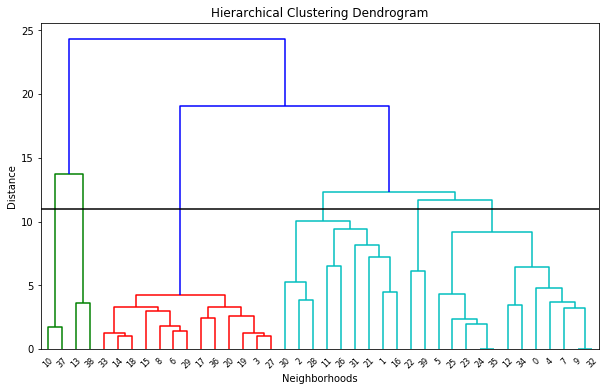

In [480]:
import scipy.cluster.hierarchy as shc

data = venues_grouped.iloc[:,3:]
plt.figure(figsize=(10, 6))   
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Neighborhoods')
plt.ylabel('Distance')
plt.axhline(y=11, c='k')
dend = shc.dendrogram(shc.linkage(data, method='ward'))

According to the above graph, I decide to separate our neighborhoods into 5 clusters (cut at distance of 11, horizontal black line). 
I will use the hierarchical agglomerative clustering of the sklearn.cluster library to cluster these neighborhoods.

In [481]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')  
clusterresult = cluster.fit_predict(data)

venues_most['NeighborhoodCluster'] = clusterresult
venues_cluster= df_neighborhood[['Neighborhood','Latitude','Longitude']].merge(venues_most[['Neighborhood','NeighborhoodCluster']])
venues_cluster.head()


,Neighborhood,Latitude,Longitude,NeighborhoodCluster
0,Aviației,44.485790,26.101219,1
1,"Băneasa, Bucharest",44.493952,26.080518,0
2,"Berceni, Bucharest",44.386430,26.128490,1
3,Bucureștii Noi,44.480413,26.042807,2
4,Centrul Civic,44.434300,26.094670,0


In [482]:
kclusters= 5
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for lat, lon, poi, cluster in zip(venues_cluster['Latitude'], venues_cluster['Longitude'], venues_cluster['Neighborhood'], venues_cluster['NeighborhoodCluster']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

According to the above graph, I decide to separate our neighborhoods into 5 clusters (cut at distance of 11, horizontal black line). I will use the hierarchical agglomerative clustering of the sklearn.cluster library to cluster these neighborhoods.